# Decide threshold

The goal of this notebook is to define a threshold to determine if a sample if PAO1 or not (likewise, if a sample is PA14 or not). We used known labels from SRA to do this. Specifically, we examined the distribution of PAO1 samples (grey) vs non-PAO1 samples (blue). We define the threshold to be one that separated between the two distributions. We use this threshold in [1_create_compendia.ipynb](1_create_compendia.ipynb) to partition gene expression data into PAO1 and PA14 compendia.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import seaborn as sns
from textwrap import fill
import matplotlib.pyplot as plt
from core_acc_modules import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Raw (TPM) expression data files
pao1_expression_filename = paths.PAO1_GE
pa14_expression_filename = paths.PA14_GE

# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

In [3]:
# Load expression data
# Matrices will be sample x gene after taking the transpose
pao1_expression = pd.read_csv(pao1_expression_filename, index_col=0, header=0).T

pa14_expression = pd.read_csv(pa14_expression_filename, index_col=0, header=0).T

# Drop row with gene ensembl ids
pao1_expression.drop(["X"], inplace=True)
pa14_expression.drop(["X"], inplace=True)

In [4]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

## Format expression data

Format index to only include experiment id. This will be used to map to expression data and SRA labels later

In [6]:
# Format expression data indices so that values can be mapped to `sample_to_strain_table`
pao1_index_processed = pao1_expression.index.str.split(".").str[0]
pa14_index_processed = pa14_expression.index.str.split(".").str[0]

print(
    f"No. of samples processed using PAO1 reference after filtering: {pao1_expression.shape}"
)
print(
    f"No. of samples processed using PA14 reference after filtering: {pa14_expression.shape}"
)
pao1_expression.index = pao1_index_processed
pa14_expression.index = pa14_index_processed

No. of samples processed using PAO1 reference after filtering: (2643, 5563)
No. of samples processed using PA14 reference after filtering: (2619, 5891)


In [7]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,186.695,41.0399,52.6869,42.5596,11.8271,49.6818,15.1125,18.9761,39.7944,7.90016,...,0,5.16485,8.34185,2.24955,16.7872,35.8977,35.3801,117.821,133.373,0
ERX541572,200.587,36.65,65.5425,40.1072,15.0975,38.9103,9.27882,13.3374,35.814,4.29789,...,0,4.02765,8.1123,2.13563,13.5472,21.0032,26.6635,109.515,99.2929,0
ERX541573,111.42,27.4148,56.0137,25.2659,18.6952,22.6177,7.28033,8.25073,22.8004,2.72297,...,0,3.55578,8.70387,2.63218,20.6529,13.5422,33.1718,47.4317,34.1095,0
ERX541574,143.32,34.4773,83.4517,39.3797,23.2258,30.0783,12.3878,11.1666,26.4343,7.74561,...,0,7.79597,9.47563,4.12049,16.6373,15.0784,24.8545,97.8814,36.5146,5.00512
ERX541575,118.398,34.014,73.7324,32.2136,21.2469,23.1491,6.74443,13.0066,33.6489,4.74327,...,0,5.56938,9.57055,2.4523,32.6727,8.08117,47.4864,66.6335,26.2999,0


In [8]:
pa14_expression.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571,7.649,5.19946,0,0.60384,3.25146,2.07243,4.73741,9.29522,14.7829,0.799833,...,12.9614,59.3176,216.062,15.6344,62.0945,12.2478,485.023,7.89171,20.5447,0
ERX541572,9.07994,5.32769,1.81816,2.99295,8.57561,2.01307,2.62795,11.8476,20.8028,1.0461,...,22.1461,83.6427,201.195,21.1028,90.7961,77.918,643.011,13.0426,18.0631,0
ERX541573,8.19844,5.34884,5.74693,6.51464,4.44288,4.59846,1.40991,11.5351,15.8012,3.56081,...,22.5625,113.387,140.01,8.23511,17.6324,75.5676,989.102,15.9628,11.4278,0
ERX541574,10.2302,1.51737,2.20543,3.78442,2.16879,4.43033,2.52313,9.35498,18.8926,2.66614,...,28.664,120.056,179.671,8.44258,20.247,72.9086,1107.97,24.7304,28.1454,0
ERX541575,8.83536,5.10013,2.70427,7.34835,4.38874,3.05368,0.652771,7.40535,11.4972,1.66304,...,14.6011,125.629,111.88,7.18445,16.4272,58.6684,720.376,17.0733,24.7502,0


## Format SRA annotations

In [9]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

assert (
    len(sample_to_strain_table_full.index.unique())
    == sample_to_strain_table_full_processed.shape[0]
)

In [10]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full_processed.index):
    if sample_to_strain_table_full_processed.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif (
        sample_to_strain_table_full_processed.loc[exp_id, "ClinicalIsolate"].all()
        == True
    ):
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full_processed["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full_processed["Strain type"].to_frame()

sample_to_strain_table.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


## Label samples with SRA annotations

In [11]:
# Label samples with SRA annotations
# pao1_expression_label = pao1_expression_binned.join(
#    sample_to_strain_table, how='left')
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
print(pao1_expression_label.shape)
pao1_expression_label.head()

(2643, 5564)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX541571,186.695,41.0399,52.6869,42.5596,11.8271,49.6818,15.1125,18.9761,39.7944,7.90016,...,5.16485,8.34185,2.24955,16.7872,35.8977,35.3801,117.821,133.373,0,NA
ERX541572,200.587,36.65,65.5425,40.1072,15.0975,38.9103,9.27882,13.3374,35.814,4.29789,...,4.02765,8.1123,2.13563,13.5472,21.0032,26.6635,109.515,99.2929,0,NA
ERX541573,111.42,27.4148,56.0137,25.2659,18.6952,22.6177,7.28033,8.25073,22.8004,2.72297,...,3.55578,8.70387,2.63218,20.6529,13.5422,33.1718,47.4317,34.1095,0,NA
ERX541574,143.32,34.4773,83.4517,39.3797,23.2258,30.0783,12.3878,11.1666,26.4343,7.74561,...,7.79597,9.47563,4.12049,16.6373,15.0784,24.8545,97.8814,36.5146,5.00512,NA
ERX541575,118.398,34.014,73.7324,32.2136,21.2469,23.1491,6.74443,13.0066,33.6489,4.74327,...,5.56938,9.57055,2.4523,32.6727,8.08117,47.4864,66.6335,26.2999,0,NA


In [12]:
print(pa14_expression_label.shape)
pa14_expression_label.head()

(2619, 5892)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845,Strain type
ERX541571,7.649,5.19946,0,0.60384,3.25146,2.07243,4.73741,9.29522,14.7829,0.799833,...,59.3176,216.062,15.6344,62.0945,12.2478,485.023,7.89171,20.5447,0,NA
ERX541572,9.07994,5.32769,1.81816,2.99295,8.57561,2.01307,2.62795,11.8476,20.8028,1.0461,...,83.6427,201.195,21.1028,90.7961,77.918,643.011,13.0426,18.0631,0,NA
ERX541573,8.19844,5.34884,5.74693,6.51464,4.44288,4.59846,1.40991,11.5351,15.8012,3.56081,...,113.387,140.01,8.23511,17.6324,75.5676,989.102,15.9628,11.4278,0,NA
ERX541574,10.2302,1.51737,2.20543,3.78442,2.16879,4.43033,2.52313,9.35498,18.8926,2.66614,...,120.056,179.671,8.44258,20.247,72.9086,1107.97,24.7304,28.1454,0,NA
ERX541575,8.83536,5.10013,2.70427,7.34835,4.38874,3.05368,0.652771,7.40535,11.4972,1.66304,...,125.629,111.88,7.18445,16.4272,58.6684,720.376,17.0733,24.7502,0,NA


## Get accessory gene expression

In [13]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [14]:
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

In [15]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression["median_acc_expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression["median_acc_expression"] = pa14_acc_expression.median(axis=1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [16]:
# Add back labels
pao1_acc_expression["Strain type"] = pao1_expression_label["Strain type"]
pa14_acc_expression["Strain type"] = pa14_expression_label["Strain type"]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
pao1_acc_expression.head()

,PA3508,PA2139,PA2104,PA3067,PA3155,PA2818,PA2184,PA0644,PA1366,PA1555.1,...,PA1388,PA0689,PA4541,PA4103,PA3066,PA4193,PA5149,PA4802,median_acc_expression,Strain type
ERX541571,2.27296,0,9.46664,8.42199,82.3497,8.33503,0.238121,1.69331,38.5358,35.3801,...,1.31863,22.3242,4.33423,0.290512,24.1161,3.93058,5.89637,1.12701,6.311616,NA
ERX541572,1.34632,0,5.23325,7.68477,62.41,6.63197,1.22196,5.47167,35.6774,26.6635,...,2.80764,20.8194,4.5941,0,18.8229,3.15489,6.55631,1.08539,6.229964,NA
ERX541573,1.26728,0,5.28905,3.83238,33.6129,5.10521,1.20415,9.13456,21.3,33.1718,...,2.69804,32.5016,4.27706,0,3.19217,1.89947,4.50014,0.529415,4.207755,NA
ERX541574,1.42054,0,8.47523,3.22655,38.9098,6.06797,1.71439,17.2541,39.9247,24.8545,...,2.13531,46.2125,7.84449,0,4.90806,2.39818,4.682,0.209584,6.659673,NA
ERX541575,0.883921,0,6.3157,2.74892,49.9672,6.0068,2.75144,12.107,31.1183,47.4864,...,1.23281,32.6853,5.61786,0.184164,4.12369,1.34895,5.23688,0.454408,5.026461,NA


In [18]:
pa14_acc_expression.head()

,PA14_62030,PA14_61340,PA14_28520,PA14_03330,PA14_55030,PA14_10830,PA14_69540,PA14_31080,PA14_15750,PA14_61410,...,PA14_15450,PA14_27690,PA14_15590,PA14_59640,PA14_71400,PA14_46590,PA14_28250,PA14_22210,median_acc_expression,Strain type
ERX541571,16.4399,27.2047,6.17352,0,0.635562,0,0,0.861973,366.336,28.8304,...,0,0,0.168461,0,134.525,0.113612,13.1012,0,0.000000,NA
ERX541572,37.3738,26.3115,9.02826,0,1.23569,0,0,1.93848,203,22.575,...,0,0,0.206667,0,24.2414,1.32827,9.6144,0,0.152917,NA
ERX541573,61.0789,44.5509,7.65607,0.230422,0.709412,0.271003,0,0.529751,181.123,35.4322,...,0,0.414569,0.222729,0.333084,39.7328,0.15974,16.1316,0,0.198142,NA
ERX541574,44.0562,21.893,6.74349,0.188065,0,0.490212,0,0,298.43,21.2011,...,0,0,0.282346,0,27.2133,0,11.0842,0,0.152538,NA
ERX541575,60.9418,10.8636,6.13674,0,0,0.381451,0.354544,0.765949,171.91,14.0761,...,0,0,0.153204,0,18.6334,0.460621,11.6311,0,0.262593,NA


In [19]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression = pao1_acc_expression.merge(
    pa14_acc_expression,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression.head()

,PA3508,PA2139,PA2104,PA3067,PA3155,PA2818,PA2184,PA0644,PA1366,PA1555.1,...,PA14_15450,PA14_27690,PA14_15590,PA14_59640,PA14_71400,PA14_46590,PA14_28250,PA14_22210,median_acc_expression_pa14,Strain type_pa14
ERX541571,2.27296,0,9.46664,8.42199,82.3497,8.33503,0.238121,1.69331,38.5358,35.3801,...,0,0,0.168461,0,134.525,0.113612,13.1012,0,0.000000,NA
ERX541572,1.34632,0,5.23325,7.68477,62.41,6.63197,1.22196,5.47167,35.6774,26.6635,...,0,0,0.206667,0,24.2414,1.32827,9.6144,0,0.152917,NA
ERX541573,1.26728,0,5.28905,3.83238,33.6129,5.10521,1.20415,9.13456,21.3,33.1718,...,0,0.414569,0.222729,0.333084,39.7328,0.15974,16.1316,0,0.198142,NA
ERX541574,1.42054,0,8.47523,3.22655,38.9098,6.06797,1.71439,17.2541,39.9247,24.8545,...,0,0,0.282346,0,27.2133,0,11.0842,0,0.152538,NA
ERX541575,0.883921,0,6.3157,2.74892,49.9672,6.0068,2.75144,12.107,31.1183,47.4864,...,0,0,0.153204,0,18.6334,0.460621,11.6311,0,0.262593,NA


## Plot distribution

In [20]:
# Get PAO1 samples that are labeled PAO1 and non-PAO1
pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] == "PAO1",
    "median_acc_expression_pao1",
]

non_pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] != "PAO1",
    "median_acc_expression_pao1",
]

In [21]:
pao1_threshold = 5

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


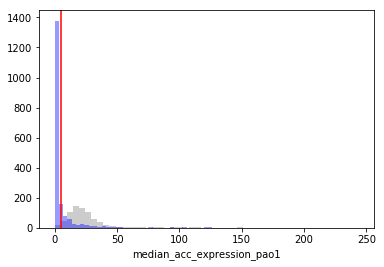

In [22]:
f = sns.distplot(pao1_sra, color="grey", kde=False)
f = sns.distplot(non_pao1_sra, color="blue", kde=False)
plt.axvline(pao1_threshold, 0, 100, color="red")

In [23]:
# Get PA14 samples that are labeled PA14 and non-PA14
pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] == "PA14",
    "median_acc_expression_pa14",
]

non_pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] != "PA14",
    "median_acc_expression_pa14",
]

In [24]:
pa14_threshold = 5

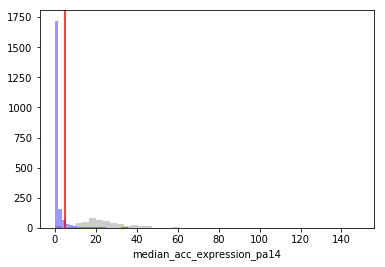

In [25]:
g = sns.distplot(pa14_sra, color="grey", kde=False)
g = sns.distplot(non_pa14_sra, color="blue", kde=False)
plt.axvline(pa14_threshold, 0, 100, color="red")

**Takeaway:**
Looks like using a threshold of 5 TPM separates between SRA-annotated PAO1 samples vs non-PAO1 samples. Similarly for PA14. This is the threshold we'll use to bin samples into PAO1 vs PA14 compendia.